# Building a FAISS-Based Vector Store: A Journey Through Data Processing and Visualization

In this notebook, you'll learn how to transform raw PDF documents into a searchable vector store using FAISS. We'll go on a journey where we:

1. **Read and extract text from PDF files.**
2. **Split the text into manageable chunks.**
3. **Display tokenization outputs from different tokenizers.**
4. **Generate embeddings from the text using a SentenceTransformer.**
5. **Store the embeddings in a FAISS index.**
6. **Project the embeddings into 2D space using UMAP for visualization.**
7. **Visualize the entire process on a scatter plot.**
8. **Incect your data into a prompt for a large language model**

In [3]:
import os
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np
from dotenv import load_dotenv
from groq import Groq


## 1. Reading Data from PDFs

First, we load PDF files from a directory, extract their text content, and combine it into one large text string.

In [4]:
### load the pdf from the path
glob_path = "data/*.pdf"
text = ""
for pdf_path in tqdm.tqdm(glob.glob(glob_path)):
    with open(pdf_path, "rb") as file:
        print(file)
        reader = PdfReader(file)
         # Extract text from all pages in the PDF
        text += " ".join(page.extract_text() for page in reader.pages if page.extract_text())

text[:50]

from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=100)
chunks = splitter.split_text(text)

print(f"{len(chunks)} Textstücke erzeugt.")
print(chunks[0][:300])

 11%|█         | 1/9 [00:00<00:01,  5.09it/s]

<_io.BufferedReader name='data\\02_Merkblatt_Vermeidung-von-Plagiaten_0916.pdf'>
<_io.BufferedReader name='data\\05_Checkliste_Sprachliche_Formale_Ausarbeitung.pdf'>


 22%|██▏       | 2/9 [00:00<00:01,  6.22it/s]

<_io.BufferedReader name='data\\Bibliotheksangebot_Bachelorarbeit_HS24FS25.pdf'>
<_io.BufferedReader name='data\\Schwerpunktthemen_fuer_Studenten.pdf'>


 44%|████▍     | 4/9 [00:00<00:00,  6.58it/s]

<_io.BufferedReader name='data\\W_MB_Merkblatt_Bachelorarbeit_BSc.pdf'>


 56%|█████▌    | 5/9 [00:01<00:01,  2.83it/s]

<_io.BufferedReader name='data\\ZHAW_Zitierleitfaden_DE.pdf'>


 67%|██████▋   | 6/9 [00:02<00:01,  1.81it/s]

<_io.BufferedReader name='data\\Z_MB_Merkblatt_Verwendung_von_generativer_KI_in_Arbeiten.pdf'>


 78%|███████▊  | 7/9 [00:02<00:01,  1.93it/s]

<_io.BufferedReader name='data\\Z_RL_Richtlinie_Anhang_Deklarationspflicht_KI_bei_Arbeiten.pdf'>


 89%|████████▉ | 8/9 [00:03<00:00,  2.04it/s]

<_io.BufferedReader name='data\\Z_RL_Richtlinie_KI_bei_Leistungsnachweisen.pdf'>


100%|██████████| 9/9 [00:04<00:00,  2.23it/s]

79 Textstücke erzeugt.
2.2.5.1 -01MB Vermeidung von Plagiaten  Dok.- Verantw.:  mart 
Version 2.0   
. 
Genehmigt  19.9.12  durch: Generalsekretär   Seite 1 von 2 
 Rektorat  
 
Ressort Lehre  
 
Merkblatt zur Vermeidung von Plagiaten  
 
Plagiate verstossen gegen grundlegende Regeln wissenschaftlichen Arbeitens. Entsprec


In [5]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
chunk_embeddings = embedding_model.encode(chunks, show_progress_bar=True)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
import faiss
import pickle

dimension = chunk_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(chunk_embeddings)

with open("faiss_index.pkl", "wb") as f:
    pickle.dump(index, f)

print("FAISS Index gespeichert.")

FAISS Index gespeichert.


In [7]:
user_query = "What is the most important factor in diagnosing asthma?"
query_embedding = embedding_model.encode([user_query])
D, I = index.search(query_embedding, k=5)
retrieved_chunks = [chunks[i] for i in I[0]]

for i, chunk in enumerate(retrieved_chunks):
    print(f"\n--- Chunk {i+1} ---\n{chunk[:500]}")



--- Chunk 1 ---
Beurteilung zusätzlich in Rücksprache mit einer Vertretung  des externen Partners.  
Die Betreuungsperson lädt das Bewertungsraster auf der Plattform «MoLeNa» hoch, zur 
Einsichtnahme durch die Studierenden4. Neben dem Ausfüllen des Bewertungsrasters erstellt 
die Betreuungsperson eine schriftliche, zusammenfassende Würdigung der Arbeit (Bestandteil 
des Bewertungsrasters).  Die Bewertenden sind verpflichtet, die Bachelorarbeit mit den 
Studierenden mündlich zu besp rechen.  
                   

--- Chunk 2 ---
bliert. Der APA-Standard respektive DGP-Standard gilt für die betriebswirtschaftlich und 
volkswirtschaftlich orientierten Arbeiten an der ZHAW School of Management and Law (SML). 
Dieser Leitfaden orientiert sich am APA-Standard (7. Auflage, 2020) und fasst die wichtigsten 
Regeln für das korrekte Zitieren zusammen. Bei Abweichungen oder Sonderfällen gelten die 
Regeln des APA-Standards.
An der SML gibt es zwei Standards:
 −Für das fachgerechte Zitieren in rec

In [8]:
context = "\n\n".join(retrieved_chunks)
prompt = f"""Beantworte die folgende Frage auf Grundlage des Kontexts:\n\n{context}\n\nFrage: {user_query}\nAntwort:"""

print(prompt[:1000])  # Zeige nur Anfang


Beantworte die folgende Frage auf Grundlage des Kontexts:

Beurteilung zusätzlich in Rücksprache mit einer Vertretung  des externen Partners.  
Die Betreuungsperson lädt das Bewertungsraster auf der Plattform «MoLeNa» hoch, zur 
Einsichtnahme durch die Studierenden4. Neben dem Ausfüllen des Bewertungsrasters erstellt 
die Betreuungsperson eine schriftliche, zusammenfassende Würdigung der Arbeit (Bestandteil 
des Bewertungsrasters).  Die Bewertenden sind verpflichtet, die Bachelorarbeit mit den 
Studierenden mündlich zu besp rechen.  
                                                
 
 
4 Die Ablage des Bewertungsrasters auf der Plattform «MoLeNa» ist erst möglich, nachdem die Studierenden  die Evaluation 
der Betreuungsleistung erbracht ha ben.  W-MB-Merkblatt Bachelorarbeit  BSc 
Version:  3.1.1 gültig ab:  01.08.202 4  Seite 11 von 11 
 School of  
Management and Law  
Zur Vergabe der Note 6.00 (mit Auszeichnung) ist eine Zweitmeinung einzuholen. Die 
Studiengangleitung regelt die De

In [9]:
from dotenv import load_dotenv
import os

# .env Datei laden
load_dotenv()




True

In [10]:
import os
from groq import Groq

# Hole und bereinige Schlüssel einmal
with open(".env") as f:
    for line in f:
        if line.startswith("GROQ_API_KEY"):
            key = line.split("=")[1].strip()

client = Groq(api_key=key)

response = client.chat.completions.create(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    messages=[{"role": "user", "content": prompt}]
)

print(response.choices[0].message.content)


Entschuldigung, aber die Frage "What is the most important factor in diagnosing asthma?" hat nichts mit dem bereitgestellten Kontext zu tun. Der Kontext befasst sich mit den Richtlinien und Anforderungen für das Verfassen einer Bachelorarbeit an der ZHAW School of Management and Law, einschließlich Zitierleitfaden, Bewertungskriterien und formalen Richtlinien. Es gibt keine Informationen zum Thema Asthma oder medizinische Diagnosen im bereitgestellten Text. Wenn Sie eine Frage zu den Richtlinien für die Bachelorarbeit haben, stehe ich Ihnen gerne zur Verfügung.


## 2. Splitting the Text into Chunks

Large texts can be difficult to work with. We use a text splitter, in this case [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/),  to break the full text into smaller, overlapping chunks. This helps preserve context when we later embed the text.

In [11]:
# Create a splitter: 2000 characters per chunk with an overlap of 200 characters
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
# Split the extracted text into manageable chunks
chunks = splitter.split_text(text)

In [12]:
print(f"Total chunks: {len(chunks)}")
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 61
Preview of the first chunk: 2.2.5.1 -01MB Vermeidung von Plagiaten  Dok.- Verantw.:  mart 
Version 2.0   
. 
Genehmigt  19.9.12  durch: Generalsekretär   Seite 1 von 2 
 Rektorat  
 
Ressort Lehre  
 
Merkblatt zur Vermeidung vo


## 3. Tokenizing the Text with Different Tokenizers

Before embedding, it's insightful to see how different tokenizers break up our text. Here, we use the tokenizer from the SentenceTransformer model (see [SentenceTransformersTokenTextSplitter](https://python.langchain.com/api_reference/text_splitters/sentence_transformers/langchain_text_splitters.sentence_transformers.SentenceTransformersTokenTextSplitter.html#sentencetransformerstokentextsplitter)).

In [13]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2")

In [14]:
token_split_texts = []
for text in chunks:
    token_split_texts += token_splitter.split_text(text)

print(f"\nTotal chunks: {len(token_split_texts)}")
print(token_split_texts[0])


Total chunks: 252
2.2.5.1 -01MB Vermeidung von Plagiaten Dok.- Verantw.: mart Version 2.0 . Genehmigt 19.9.12 durch: Generalsekretär Seite 1 von 2 Rektorat Ressort Lehre Merkblatt zur Vermeidung von Plagiaten Plagiate verstossen gegen grundlegende Regeln wissenschaftlichen Arbeitens. Entsprechend s e- hen das Gesetz und die Rahmenprüfungsordnung für Bachelor - und Masterstudi engänge der ZHAW (RPO) in Plagiatsfällen zum Teil gravierende Sanktionen für Studierende vor. Dieses Mer k- blatt soll 


In [15]:
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁2.2', '.', '5.1', '▁', '-01', 'MB', '▁Verme', 'i', 'dung', '▁von', '▁Pla', 'gia', 'ten', '▁Dok', '.', '-', '▁Ver', 'ant', 'w', '.', ':', '▁mart', '▁Version', '▁2.0', '▁', '.', '▁Ge', 'nehm', 'igt', '▁19', '.9.', '12', '▁durch', ':', '▁General', 'sekretär', '▁Seite', '▁1', '▁von', '▁2', '▁Rektor', 'at', '▁Res', 'sort', '▁Lehr', 'e', '▁Merk', 'blatt', '▁zur', '▁Verme', 'i', 'dung', '▁von', '▁Pla', 'gia', 'ten', '▁Pla', 'gia', 'te', '▁vers', 'to', 'ssen', '▁gegen', '▁grundlegende', '▁Regeln', '▁', 'wissenschaftlich', 'en', '▁Arbeiten', 's', '.', '▁Ent', 'sprechen', 'd', '▁s', '▁e', '-', '▁hen', '▁das', '▁Gesetz', '▁und', '▁die', '▁Rahmen', 'prüfung', 's', 'ordnung', '▁für', '▁Bachelor', '▁-', '▁und', '▁Master', 'studi', '▁en', 'gänge', '▁der', '▁Z', 'HA', 'W', '▁(', 'R', 'PO', ')', '▁in', '▁Pla', 'gia', 'ts', 'fälle', 'n', '▁zum', '▁Teil', '▁gravi', 'erende', '▁San', 'ktion', 'en', '▁für', '▁Studi', 'erende', '▁vor', '.', '▁Dieses', '▁Mer', '▁k', '-', '▁', 'blatt', '</s

In [16]:
model_name = "Sahajtomar/German-semantic"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['[CLS]', '2', '.', '2', '.', '5', '.', '1', '-', '01', '##MB', 'Vermeidung', 'von', 'Pla', '##gia', '##ten', 'Dok', '.', '-', 'Veran', '##tw', '.', ':', 'mar', '##t', 'Version', '2', '.', '0', '.', 'Genehm', '##igt', '19', '.', '9', '.', '12', 'durch', ':', 'Generalsekretär', 'Seite', '1', 'von', '2', 'Rektor', '##at', 'Ressort', 'Lehre', 'Merk', '##blatt', 'zur', 'Vermeidung', 'von', 'Pla', '##gia', '##ten', 'Pla', '##gia', '##te', 'verst', '##ossen', 'gegen', 'grundlegende', 'Regeln', 'wissenschaft', '##lichen', 'Arbeiten', '##s', '.', 'Entsprechend', 's', 'e', '-', 'hen', 'das', 'Gesetz', 'und', 'die', 'Rahmen', '##prüfung', '##sor', '##dn', '##ung', 'für', 'Bachelor', '-', 'und', 'Masters', '##tu', '##di', 'eng', '##änge', 'der', 'Z', '##H', '##AW', '(', 'R', '##PO', ')', 'in', 'Pla', '##gia', '##ts', '##fällen', 'zum', 'Teil', 'grav', '##ierende', 'Sanktionen', 'für', 'Studierende', 'vor', '.', 'Dieses', 'Mer', 'k', '-', 'bl', '##att', 'soll', '[SEP]']
Chunk 1: ['[CLS]',

## 4. Generating Embeddings for Each Chunk

Now we convert each text chunk into a numerical embedding that captures its semantic meaning. These embeddings will be used for similarity search.

In [17]:
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

C:\Users\dev\AppData\Local\Temp\ipykernel_11044\4090508586.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")


## 5. Building a FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.

In [18]:
d = chunk_embeddings.shape[1]
print(d)

1024


In [19]:
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 252


In [20]:
if not os.path.exists('faiss'):
    os.makedirs('faiss')
    
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(chunks, f)

In [21]:
index_2 = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts_2 = pickle.load(f)
print(len(token_split_texts_2))
print(len(token_split_texts))

61
252


## 6. Projecting Embeddings with UMAP

To visualize high-dimensional embeddings, we use UMAP to project them into 2D space. You can project both the entire dataset and individual query embeddings.

In [22]:
# Fit UMAP on the full dataset embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


C:\Users\dev\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\dev\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [23]:
# Project the entire dataset embeddings
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings:   0%|          | 0/252 [00:00<?, ?it/s]C:\Users\dev\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 1/252 [00:03<14:52,  3.56s/it]C:\Users\dev\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\dev\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\dev\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users

Projected dataset embeddings shape: (252, 2)


## 7. Querying the Vector Store and Projecting Results

We now define a retrieval function that takes a text query, embeds it, and searches our FAISS index for similar documents. We then project these result embeddings with UMAP.
"""

In [24]:
def retrieve(query, k=5):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances[0]

In [25]:
query = "KI während der Bachelorarbeit"
results, result_embeddings, distances = retrieve(query, k=3)
print("Retrieved document preview:")
print(results[0][:300])

Retrieved document preview:
(2012). Die Chefs von morgen: Kompetent und kritisch. io Management, 2012(5), 12-15. Zitierleitfaden | 19 Zitierleitfaden | 20 Generative Systeme, die auf Künstlicher Intelligenz (KI) basieren, gehören zunehmend zur neuen Studien- und Berufsrealität von Lehrenden und Lernenden. Die Richtlinie KI bei


In [26]:
# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

Projecting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]C:\Users\dev\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\dev\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\dev\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\dev\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embedding

## 8. Visualizing the Results

Finally, we create a scatter plot to visualize the entire dataset, the retrieved results, and the original query in 2D space.

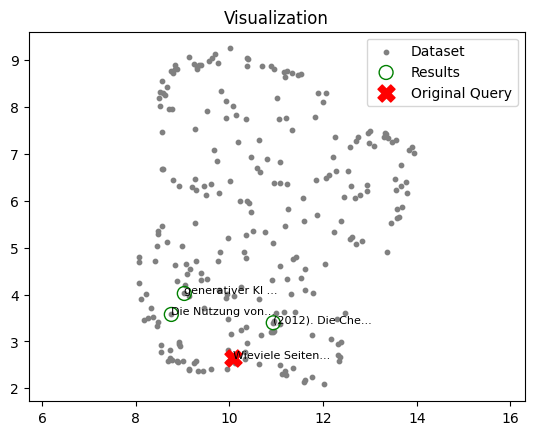

In [27]:

def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Scatter plots
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'Welche hilfsmittel sind erlaubt?'  # Replace with your actual query text if needed
original_query_text = 'Wieviele Seiten muss die Arbeit sein?'  # Replace with your actual query text if needed

plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Visualization')
plt.legend()
plt.show()


---

# 📝 Task: Semantic Retrieval-Augmented Question Answering Using Groq LLM

## Objective
Implement a question-answering system that:
1. Retrieves the most semantically relevant text passages to a user query.
2. Constructs a natural language prompt based on the retrieved content.
3. Uses a large language model (LLM) hosted by Groq to generate an answer.

---

## Task Breakdown

### 1. Embedding-Based Semantic Retrieval
- Use the `SentenceTransformer` model `"Sahajtomar/German-semantic"` to encode a user query into a dense vector embedding.
- Perform a nearest-neighbor search in a prebuilt FAISS index to retrieve the top-**k** similar text chunks. You can **use the prebuilt FAISS form above**.


### 2. LLM Prompt Construction and Query Answering
- Build the prompt:
  - Using the retrieved text chunks, concatenates the results into a context block.
  - Builds a **prompt** asking the LLM to answer the question using that context.
  - Sends the prompt to the **Groq LLM API** (`llama-3.3-70b-versatile`) and returns the response.

### 3. User Query Execution
- An example query (`"What is the most important factor in diagnosing asthma?"`) is used to demonstrate the pipeline.
- The final answer from the LLM is printed.


## Tools & Models Used
- **SentenceTransformers** (`Sahajtomar/German-semantic`) for embedding generation.
- **FAISS** for efficient vector similarity search.
- **Groq LLM API** (`llama-3.3-70b-versatile`) for generating the final response.


In [28]:
load_dotenv()
# Access the API key using the variable name defined in the .env file
groq_api_key = os.getenv("GROQ_API_KEY")

## Task 1: Embedding-Based Semantic Retrieval

In [30]:
def retrieve(query, k=5):
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances[0]

user_query_task1 = "Wie soll KI in wissenschaftlichen Arbeiten deklariert werden?"
k_results = 3

retrieved_texts_task1, retrieved_embeddings_task1, distances_task1 = retrieve(user_query_task1, k=k_results)

print(f"Benutzeranfrage: \"{user_query_task1}\"\n")
print(f"Die Top-{k_results} ähnlichsten Text-Chunks sind:\n")
for i, text_chunk in enumerate(retrieved_texts_task1):
    print(f"--- Chunk {i+1} (Distanz: {distances_task1[i]:.4f}) ---")
    print(text_chunk[:500])
    print("...\n")

Benutzeranfrage: "Wie soll KI in wissenschaftlichen Arbeiten deklariert werden?"

Die Top-3 ähnlichsten Text-Chunks sind:

--- Chunk 1 (Distanz: 299.8222) ---
für die Anwendung von Sprachtechnologien und sensibilisierte für d ie kritische Reflexion deren Verwendung in meiner Arbeit. Andererseits wurden KI -Tools u.a. für das Recherchieren von Literatur, das Strukturieren der Arbeit in Unter- kapitel, das Zusammenfassen von Literatur, das Verstehen von Inhalten, das Formulieren von Texten, oder die Bildgenerierung verwendet. Es kann hierfür auf das sp ezifische Verzeichnis verwiesen werden. [...] Beispiel Z-RL-Richtlinie Anhang Deklarationspflicht KI b
...

--- Chunk 2 (Distanz: 315.2643) ---
zielführend noch praktikabel. Im Sinne der Eigenleistung bzw. wissenschaftlichen Integrität muss die Ver - wendung von KI jedoch bestmöglich transparent gemacht werden. Grundsätzlich gilt daher eine Deklarationspflicht für alle generativen KI-Systeme, welche die Qualität einer Arbeit auf inhaltli- 

## Taks 2: LLM Prompt Construction and Query Answering

In [31]:
context_string_task2 = "\n\n".join(retrieved_texts_task1)

prompt_task2 = f"""Beantworten Sie die folgende Frage ausschließlich auf Grundlage des bereitgestellten Kontexts:

Kontext:
{context_string_task2}

Frage: {user_query_task1}

Antwort:"""

groq_api_key = os.getenv("GROQ_API_KEY")

if not groq_api_key:
    print("GROQ_API_KEY nicht gefunden. Bitte stellen Sie sicher, dass er in Ihrer .env Datei oder Umgebungsvariable gesetzt ist.")
else:
    client = Groq(api_key=groq_api_key)
    
    try:
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt_task2,
                }
            ],
            model="llama3-70b-8192",
        )
        
        llm_answer_task2 = chat_completion.choices[0].message.content
        print("\nAntwort des LLM:\n")
        print(llm_answer_task2)
        
    except Exception as e:
        print(f"Ein Fehler ist bei der Kommunikation mit der Groq API aufgetreten: {e}")


Antwort des LLM:

Die Verwendung von KI in wissenschaftlichen Arbeiten soll transparent gemacht werden. Eine Deklarationspflicht gilt für alle generativen KI-Systeme, die die Qualität einer Arbeit auf inhaltlicher Ebene beeinflussen. Die Deklaration soll in der Einleitung zur Arbeit oder im Methodenabschnitt erfolgen und muss beschreiben, wie generative KI-Systeme in der Arbeit verwendet wurden, einschließlich der Frage, inwieweit sie als Gedankenanstoss oder als Inspirationsquelle verwendet wurden. Außerdem muss jede wörtliche, paraphrasierende oder sinngemäße Übernahme von Output aus generativen KI-Systemen an der entsprechenden Stelle gekennzeichnet werden.


## Task 3: User Query Execution

In [32]:
def retrieve(query, k=5):
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances[0]

user_query_task3 = "What is the most important factor in diagnosing asthma?"
k_results_task3 = 3

retrieved_texts_task3, retrieved_embeddings_task3, distances_task3 = retrieve(user_query_task3, k=k_results_task3)

context_string_task3 = "\n\n".join(retrieved_texts_task3)

prompt_task3 = f"""Beantworten Sie die folgende Frage ausschließlich auf Grundlage des bereitgestellten Kontexts:

Kontext:
{context_string_task3}

Frage: {user_query_task3}

Antwort:"""

groq_api_key = os.getenv("GROQ_API_KEY")

if not groq_api_key:
    print("GROQ_API_KEY nicht gefunden. Bitte stellen Sie sicher, dass er in Ihrer .env Datei oder Umgebungsvariable gesetzt ist.")
else:
    client = Groq(api_key=groq_api_key)
    
    try:
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt_task3,
                }
            ],
            model="llama3-70b-8192",
        )
        
        llm_answer_task3 = chat_completion.choices[0].message.content
        print(f"Benutzeranfrage: \"{user_query_task3}\"\n")
        print("Abgerufene Chunks für Kontext (erste 50 Zeichen pro Chunk):\n")
        for i, text_chunk in enumerate(retrieved_texts_task3):
            print(f"--- Chunk {i+1} (Distanz: {distances_task3[i]:.4f}) ---")
            print(text_chunk[:50])
            print("...\n")
            
        print("\nFinale Antwort des LLM:\n")
        print(llm_answer_task3)
        
    except Exception as e:
        print(f"Ein Fehler ist bei der Kommunikation mit der Groq API aufgetreten: {e}")

Benutzeranfrage: "What is the most important factor in diagnosing asthma?"

Abgerufene Chunks für Kontext (erste 50 Zeichen pro Chunk):

--- Chunk 1 (Distanz: 546.4895) ---
.S. Food and Drug Administration. (2009). Smoking 
...

--- Chunk 2 (Distanz: 614.4813) ---
TES) 12. BILD- UND TONDOKUMENTE 13. EINTRAG IN NAC
...

--- Chunk 3 (Distanz: 618.6613) ---
Review, 69(6), 12-135. Muldoon, K., Towse, J., Sim
...


Finale Antwort des LLM:

I apologize, but the provided context does not provide any information about diagnosing asthma or the most important factor in doing so. The context appears to be a citation guide, providing examples of how to cite different types of sources, and a brief mention of the FDA's website on smoking cessation products. There is no mention of asthma or its diagnosis.
